<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter4/4_5_%E3%83%88%E3%83%94%E3%83%83%E3%82%AF%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# トピックモデル

In [1]:
#@title install package
!pip install japanize-matplotlib==1.1.3
!pip install watermark

## エラーで動かない場合は、以下をコメントアウトして書籍に記載のバージョンに揃えてください。
# !pip install arviz==0.11.4
# !pip install tensorflow_probability==0.14.1
# !pip install tensorflow==2.7.0

     |████████████████████████████████| 4.1 MB 4.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=6ab086083eba9e32660050bf2d629f7adcc268d4d850f25a3cb4099c64c9a7d3
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [2]:
#@title import packages
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib 
import arviz as az

import tensorflow_probability as tfp
import tensorflow as tf
tfb = tfp.bijectors
tfd = tfp.distributions

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
colors = sns.color_palette('tab10')
japanize_matplotlib.japanize() 

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
#@title utility function
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}
    # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)


## データ

In [4]:
K = 4
V = 30
M = 20

# 事前分布のパラメータ
alpha = np.ones(K) * 0.8
beta = np.ones(V) * 0.2

np.random.seed(2)
# θを事前分布からサンプリング
topic_dist = np.random.dirichlet(alpha, size=M)
# φを事前分布からサンプリング
word_dist = np.random.dirichlet(beta, size=K)

# 文書あたりの単語数はポアソン分布に従うとする
avg_doc_len = 60
N = np.random.poisson(avg_doc_len, M)

documents = []
for i in range(M):
    # モデル式に従い、単語をサンプリング
    topics = np.random.choice(K, p=topic_dist[i], size=N[i])
    words = [np.random.choice(V, p=word_dist[j]) for j in topics]
    documents.append(words)

In [5]:
print(documents[0])

[27, 1, 11, 25, 15, 9, 11, 18, 11, 18, 17, 22, 7, 19, 1, 17, 29, 9, 22, 22, 16, 4, 2, 22, 6, 1, 29, 29, 29, 7, 14, 7, 10, 29, 25, 27, 10, 16, 19, 10, 16, 11, 15, 6, 16, 17, 18, 10, 1, 29, 21, 10, 29, 19, 29, 18, 6, 4, 22, 16, 9, 16, 16, 26, 2, 4, 7, 2, 29, 9, 16, 18, 25, 6, 10, 15, 1, 16, 19, 29]


In [6]:
# 数字のIDだと分かりづらいので、適当に具体的な単語を割り当てたデータを作成
sports = ['サッカー', 'テニス', 'ボール', '選手', '打つ', '監督', '走る', 'オリンピック', '優勝']
politics = ['会見', '議員', '投票', '補欠', '辞任', '首相', '答える', '自民党', '表明する']
entertainment = ['俳優', '演じる', 'ドラマ', '放送', '出演する', '人気', '舞台', 'スクープ', 'テレビ']
technology = ['PC', '勝敗', 'ゲーム', 'モバイル', '新作', '発売する', '電源', 'インストール']
word_lists = [sports, politics, entertainment, technology]

id2word = {i: '' for i in range(V)}

word_id_topic_prob = sorted(zip(range(V), word_dist.argmax(axis=0), word_dist.max(axis=0)), key=lambda x: x[2], reverse=True)
for i in word_id_topic_prob[:25]:
    id2word[i[0]] = word_lists[i[1]].pop(0)

random_words = ['大きい', '誤る', '気温', '子供', '分かる']
for i in id2word:
    if id2word[i] == '':
        id2word[i] = random_words.pop()

with open('vocab.txt', 'w') as f:
    for w in id2word.values():
        f.write(w + '\n')

In [7]:
with open('vocab.txt') as f:
   words = f.read().split()

# key: 単語ID, value: 単語
id2word = {i: j for i, j in enumerate(words)}

In [8]:
doc = [id2word[x] for x in documents[0]]
print('Document')
print(doc)

from collections import Counter
print('\nBag of words')
# 単語の出現回数を数え、回数が多い順に表示
print(Counter(doc).most_common())

Document
['モバイル', 'PC', '投票', 'ドラマ', '監督', 'ボール', '投票', '補欠', '投票', '補欠', '辞任', '議員', '演じる', '勝敗', 'PC', '辞任', '会見', 'ボール', '議員', '議員', 'サッカー', 'ゲーム', '俳優', '議員', 'テニス', 'PC', '会見', '会見', '会見', '演じる', '打つ', '演じる', '選手', '会見', 'ドラマ', 'モバイル', '選手', 'サッカー', '勝敗', '選手', 'サッカー', '投票', '監督', 'テニス', 'サッカー', '辞任', '補欠', '選手', 'PC', '会見', '走る', '選手', '会見', '勝敗', '会見', '補欠', 'テニス', 'ゲーム', '議員', 'サッカー', 'ボール', 'サッカー', 'サッカー', 'オリンピック', '俳優', 'ゲーム', '演じる', '俳優', '会見', 'ボール', 'サッカー', '補欠', 'ドラマ', 'テニス', '選手', '監督', 'PC', 'サッカー', '勝敗', '会見']

Bag of words
[('会見', 10), ('サッカー', 9), ('選手', 6), ('PC', 5), ('補欠', 5), ('議員', 5), ('投票', 4), ('ボール', 4), ('演じる', 4), ('勝敗', 4), ('テニス', 4), ('ドラマ', 3), ('監督', 3), ('辞任', 3), ('ゲーム', 3), ('俳優', 3), ('モバイル', 2), ('打つ', 1), ('走る', 1), ('オリンピック', 1)]


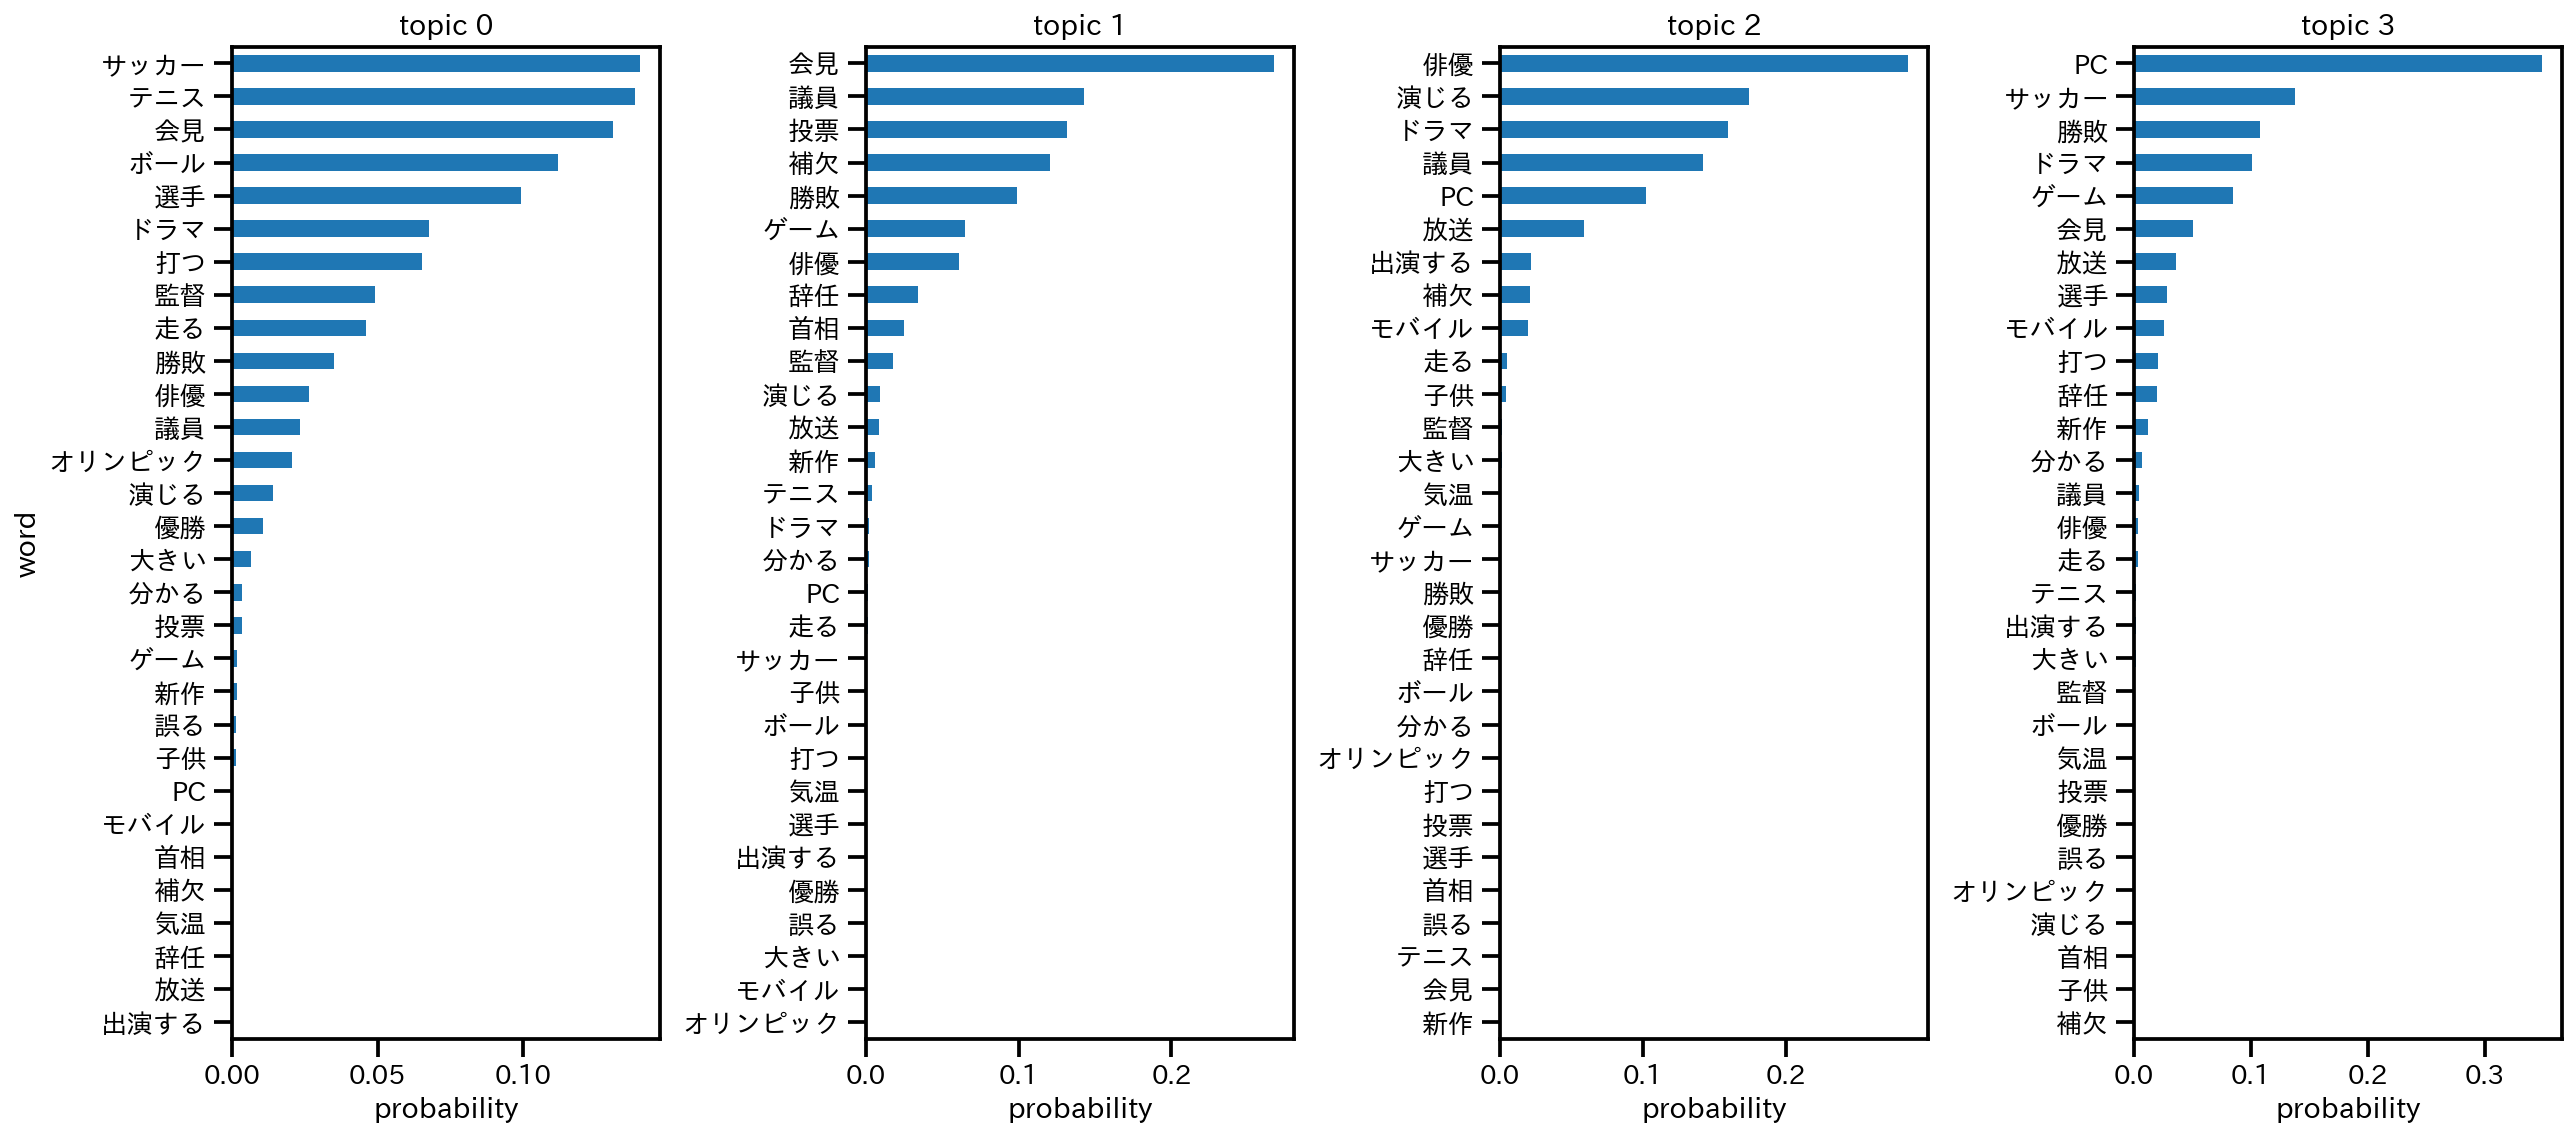

In [9]:
fig, axes = plt.subplots(1, K, figsize=(18, 8))
for i in range(K):
    ax = axes[i]
    s = pd.Series(word_dist[i]).sort_values()
    s.index = s.index.map(id2word)
    s.plot.barh(ax=ax)
    ax.set_title(f'topic {i}')
    ax.set_xlabel('probability')
    if i == 0:
        ax.set_ylabel('word')
plt.tight_layout()

Text(0, 0.5, 'number of words')

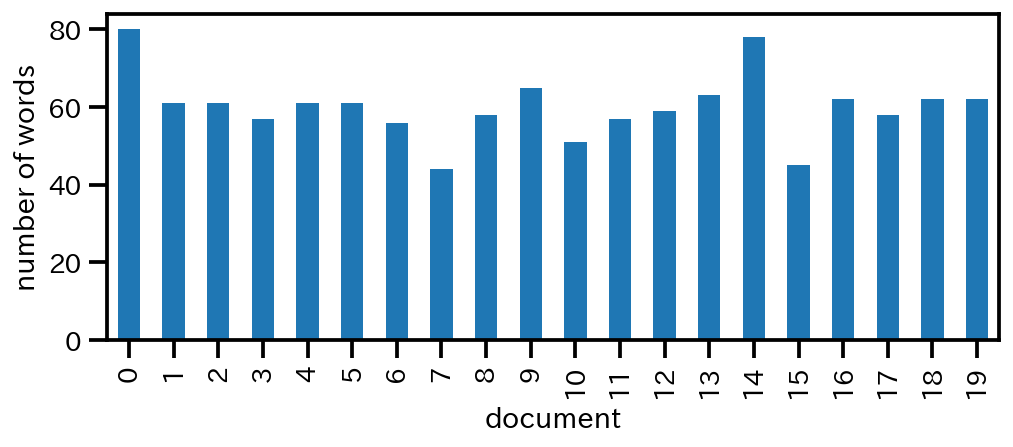

In [10]:
pd.Series(N).plot.bar(figsize=(8, 3))
plt.xlabel('document')
plt.ylabel('number of words')

## モデル

In [11]:
Root = tfd.JointDistributionCoroutine.Root
def lda_model():
    # 文書におけるトピックの分布
    theta = yield Root(tfd.Independent(
        tfd.Dirichlet(concentration=tf.ones([M, K])),
        reinterpreted_batch_ndims=1,
        name='theta')) # event shape: M, K
    
    # トピックにおける単語の分布
    phi = yield Root(tfd.Independent(
        tfd.Dirichlet(concentration=tf.ones([K, V])),
        reinterpreted_batch_ndims=1,
        name='phi')) # event shape: K, V
    
    for m in range(M):
        # 観測される単語の分布
        y = yield tfd.Sample(
            # トピック割り当てzについて周辺化したモデル
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(
                    probs=theta[..., m, :]), # カテゴリ数：K
                components_distribution=tfd.Categorical(
                    probs=phi)), # カテゴリ数：V 
            sample_shape=N[m], 
            name=f'y_{m}') # event shape: n, カテゴリ数： V

lda = tfd.JointDistributionCoroutine(lda_model)

In [12]:
def target_log_prob_fn(theta, phi):
    return lda.log_prob(theta, phi, *documents)

## 推論

In [13]:
num_results = 1000
num_burnin_steps = 500

tf.random.set_seed(42)

# パラメータの初期値
initial_state = [
    tf.fill([M, K], value=1/K, name='theta'),
    tf.fill([K, V], value=1/V, name='phi')
]

# パラメータの制約に合わせた変数変換
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.SoftmaxCentered(),
]

In [14]:
%%time
# HMC法によるサンプリング用の関数
@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    # HMCのステップサイズを自動的に調整
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        # Bijectorを利用して変数の制約に対処
        tfp.mcmc.TransformedTransitionKernel(
            # HMC法
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=target_log_prob_fn,
                 step_size=0.1,
                 num_leapfrog_steps=5),
            bijector=unconstraining_bijectors),
         num_adaptation_steps=400),
    trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

[theta, phi], is_accepted = sample()

print('acceptance rate: {:.1%}'.format(is_accepted.numpy().mean()))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/__init__.py:71: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  'TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The '


acceptance rate: 72.8%
CPU times: user 1min 14s, sys: 1.07 s, total: 1min 15s
Wall time: 1min 11s


## 推論結果

In [15]:
trace = format_trace([theta, phi], ['theta', 'phi'])
# az.plot_trace(trace)

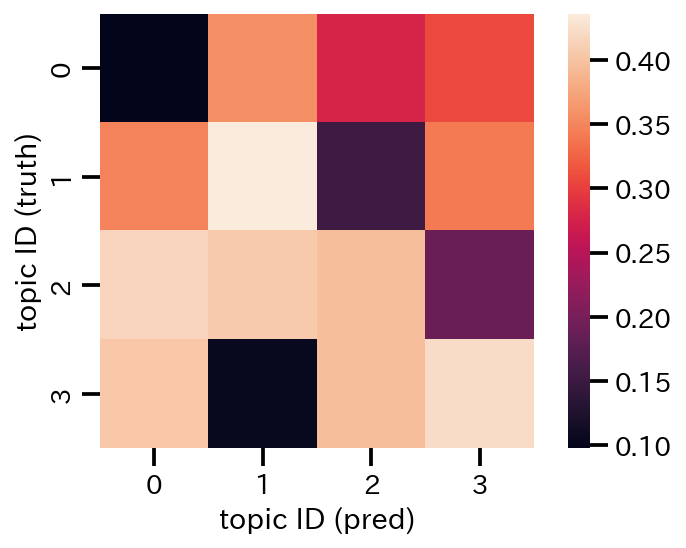

In [16]:
# topicの順番には必然性がないため、真のパラメータと入れ替わっている可能性がある。
# word distributionに基づき、トピックの順番を揃える
from scipy.spatial import distance_matrix
dist_mat = distance_matrix(word_dist, np.mean(phi.numpy(), axis=0))
sns.heatmap(dist_mat, square=True)
plt.xlabel('topic ID (pred)')
plt.ylabel('topic ID (truth)')

permute_id = [dist_mat[i].argmin() for i in range(K)]
assert len(set(permute_id)) == K # トピックが一対一対応しているか確認

In [17]:
phi_p = phi.numpy()[:, permute_id, :]
theta_p = theta.numpy()[:, :, permute_id]

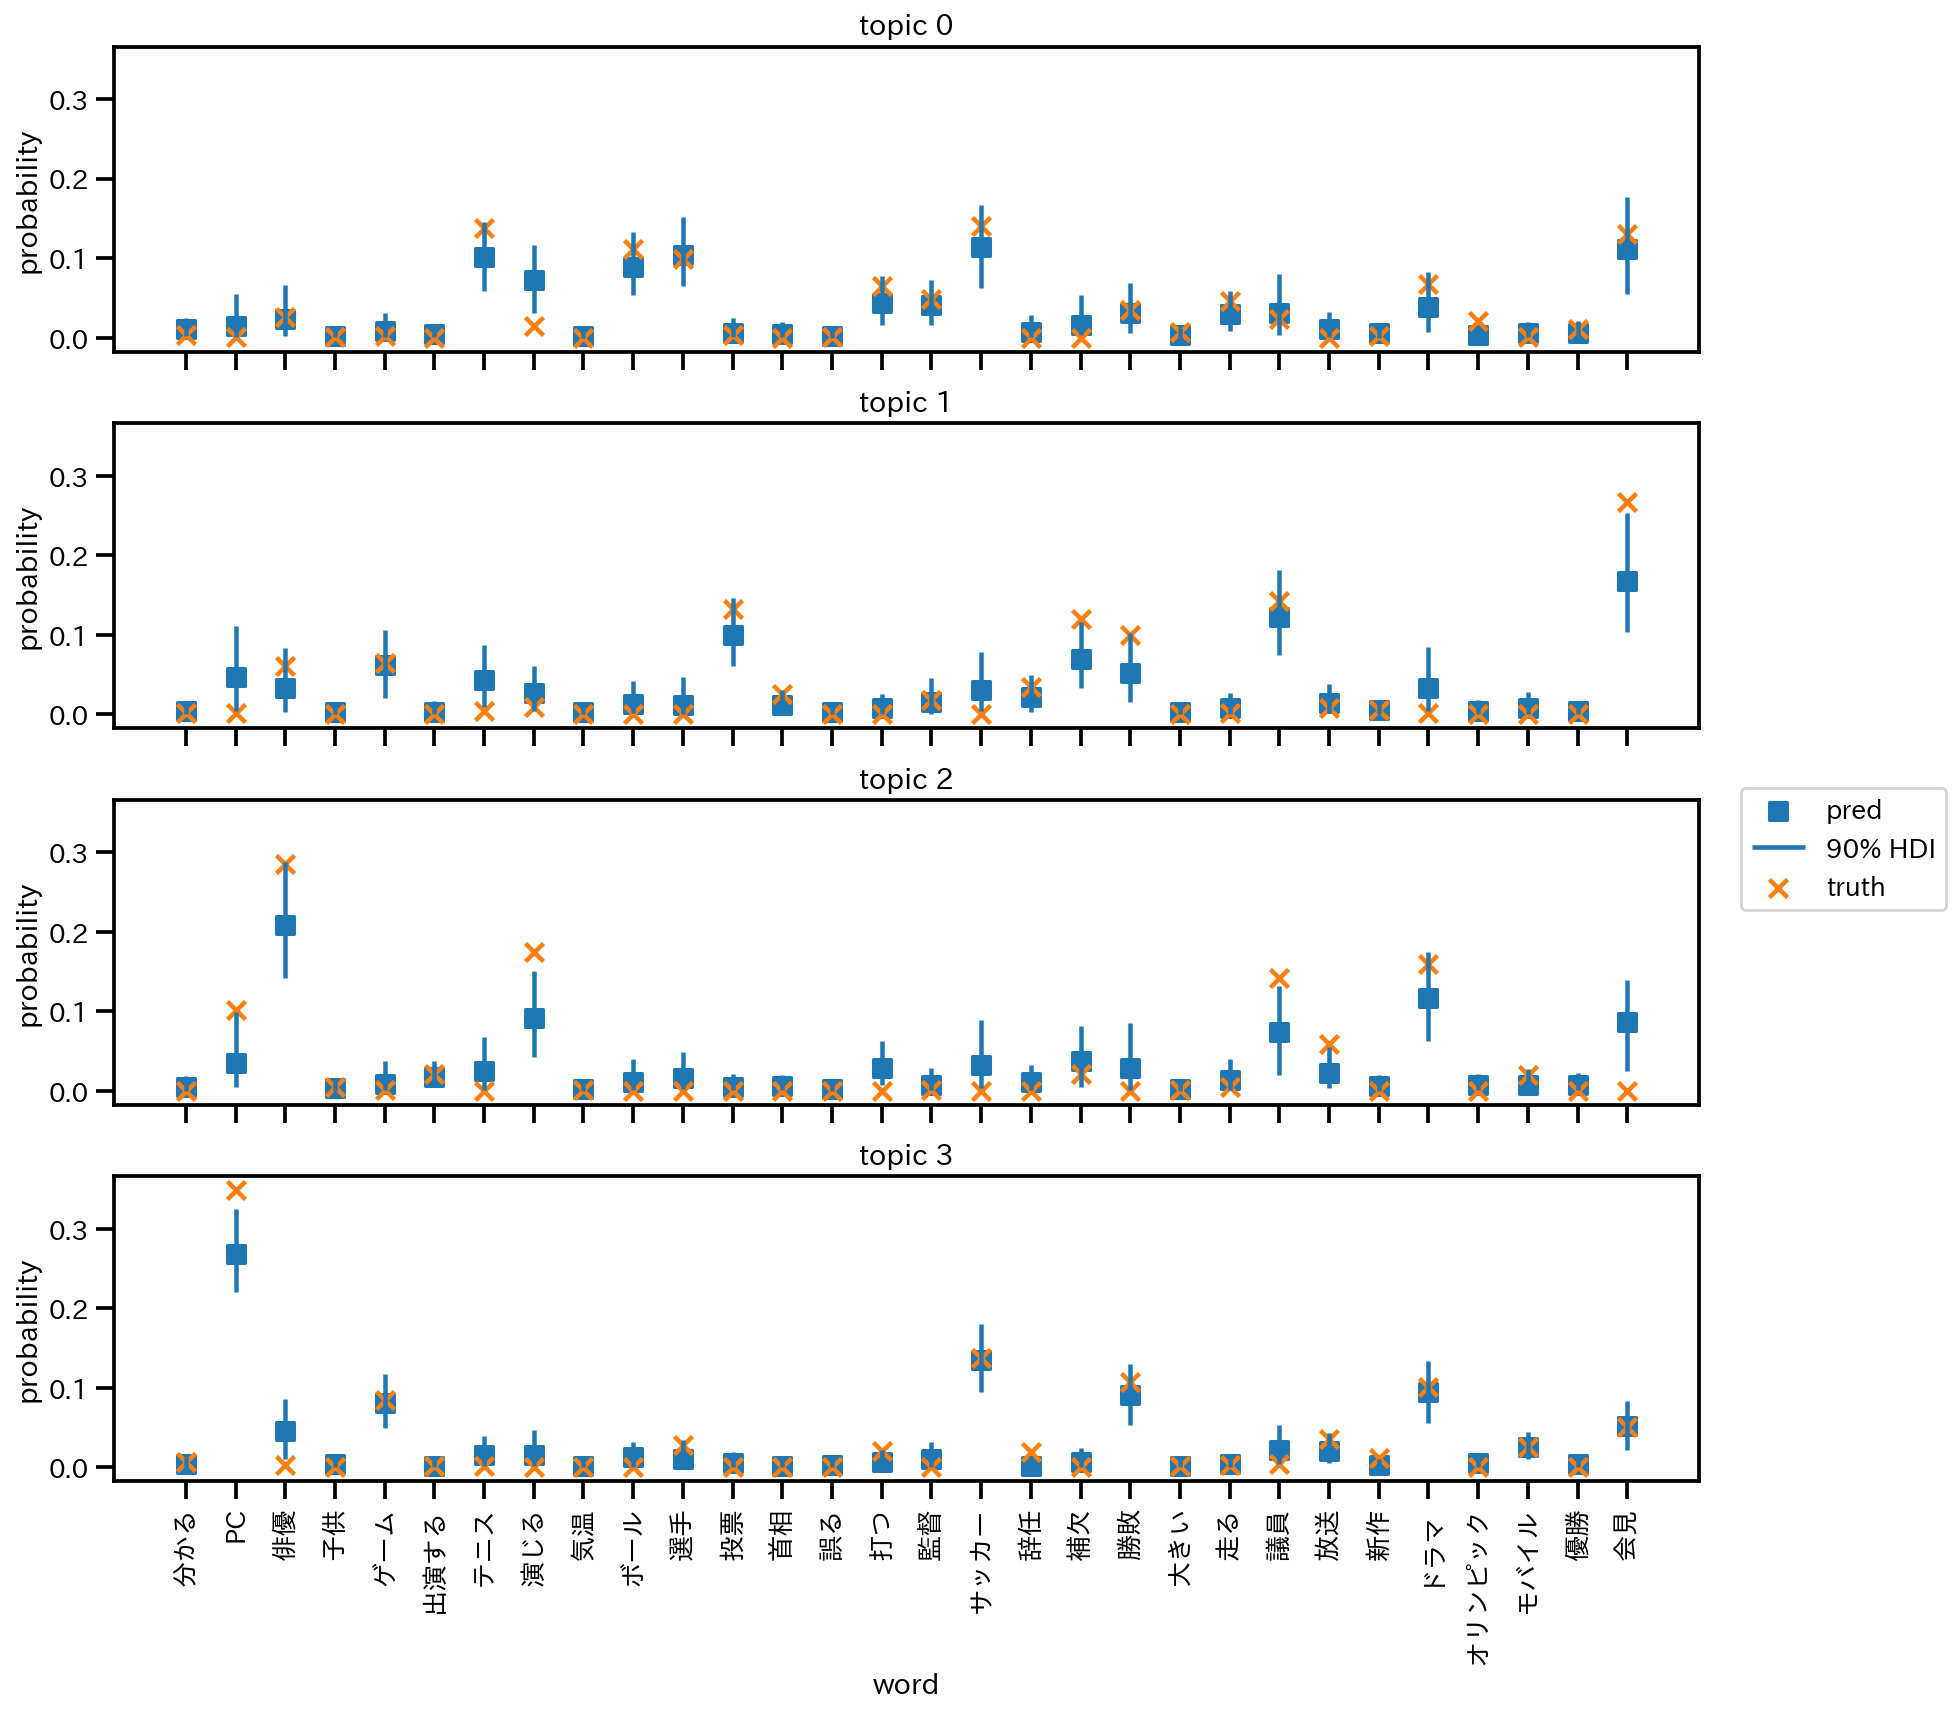

In [18]:
# (1 - a) x 100% のサンプルが入る区間を求める
a = 0.1
lwr, med, upr = np.quantile(phi_p, [a / 2, 0.5, 1 - a / 2], axis=0)

# 描画用
xticks = range(V)
vocabs = id2word.values()

fig, axes = plt.subplots(K, 1, sharex=True, sharey=True, figsize=(12, 3*K))

for i in range(K):
    ax = axes[i]
    ax.scatter(range(V), med[i], color=colors[0], marker='s', label='pred')
    ax.vlines(range(V), lwr[i], upr[i], color=colors[0], label=f'{1-a:.0%} HDI')
    ax.scatter(range(V), word_dist[i], color=colors[1], marker='x', label='truth')
    if i == K - 1:
        ax.set_xlabel('word')
    ax.set_ylabel('probability')
    ax.set_xticks(xticks)
    ax.set_xticklabels(vocabs, rotation=90)
    ax.set_title(f'topic {i}')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.tight_layout()

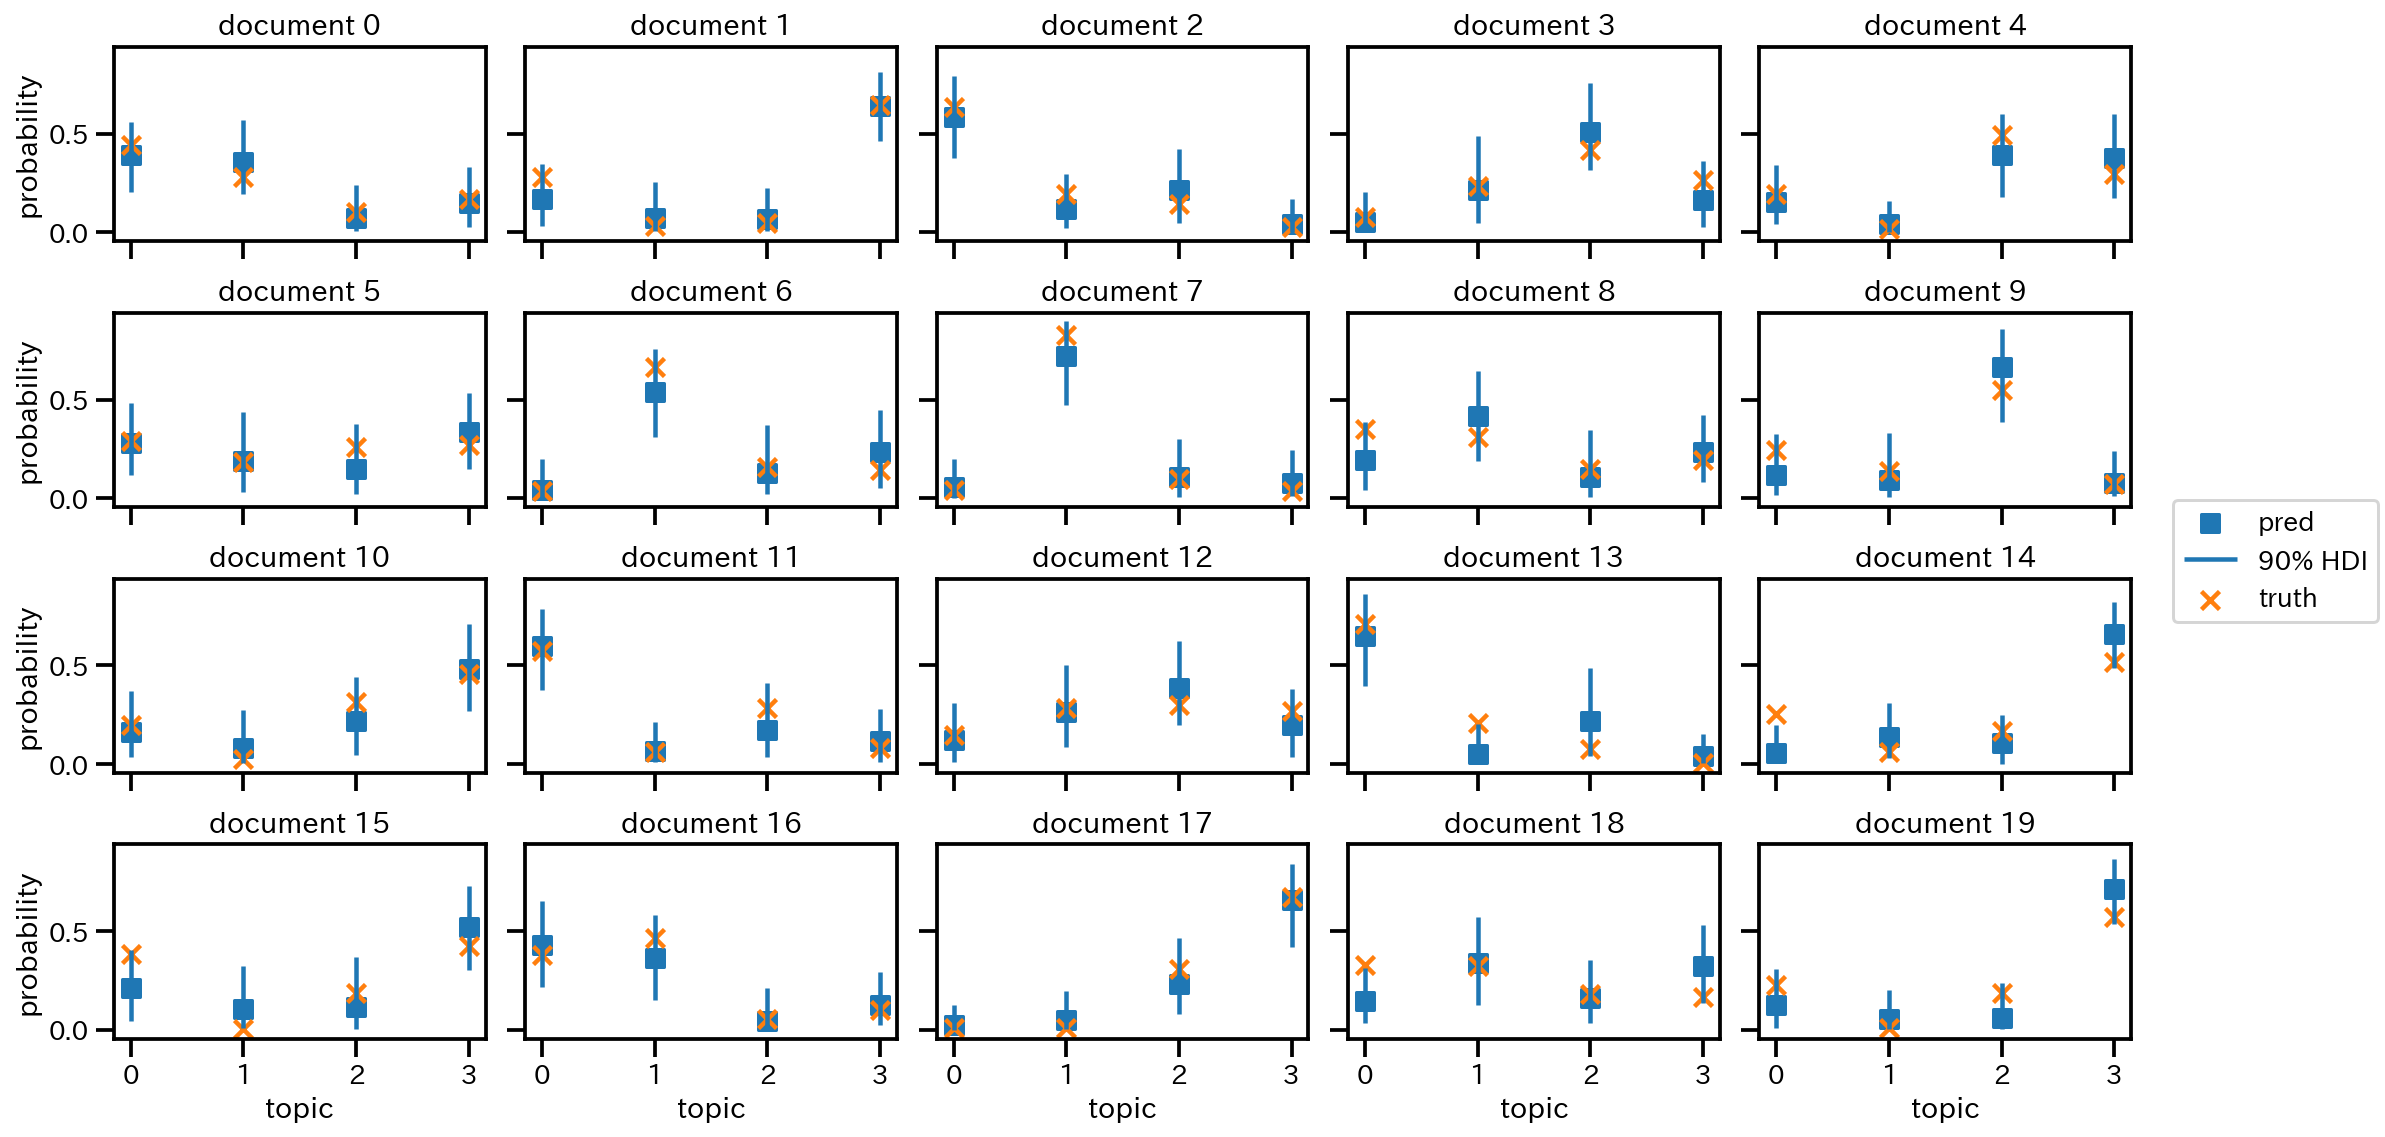

In [19]:
a = 0.1
lwr, med, upr = np.quantile(theta_p, [a / 2, 0.5, 1 - a / 2], axis=0)

ncol = 5
nrow = round(np.ceil(M/ncol))
fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(ncol*3, nrow*2))

for i in range(M):
    ax = axes.ravel()[i]
    ax.scatter(range(K), med[i], color=colors[0], marker='s', label='pred')
    ax.vlines(range(K), lwr[i], upr[i], color=colors[0], label=f'{1-a:.0%} HDI')
    ax.scatter(range(K), topic_dist[i], color=colors[1], marker='x', label='truth')
    # ax.legend()
    ax.set_xticks(range(K))
    if i >= ncol * (nrow-1): 
        ax.set_xlabel('topic')
    if not i % ncol:
        ax.set_ylabel('probability')
    ax.set_title(f'document {i}')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.tight_layout()

In [20]:
%load_ext watermark
%watermark --iversions

pandas                : 1.3.5
arviz                 : 0.12.1
japanize_matplotlib   : 1.1.3
tensorflow            : 2.8.0+zzzcolab20220506162203
seaborn               : 0.11.2
matplotlib            : 3.2.2
numpy                 : 1.21.6
IPython               : 5.5.0
tensorflow_probability: 0.16.0

